In [1]:
# default_exp core

# module name here

> API details.

In [2]:
#hide
from nbdev.showdoc import *

In [3]:
# export
from pathlib import Path
import os
import yaml
import pandas as pd
import requests
import tarfile
from fastprogress.fastprogress import master_bar, progress_bar
import matplotlib.pyplot as plt
from typing import Sequence, Tuple, TypeVar, Union
from typing import Any, AnyStr, Callable, Collection, Dict, Hashable, Iterator, List, Mapping, NewType, Optional

In [4]:
# export
class Config:
    config_path = Path(os.getenv('SHOTCHART_HOME', '~/.shot_chart')).expanduser()
    config_file = config_path/'config.yml'

    def __init__(self):
        self.config_path.mkdir(parents=True, exist_ok=True)
        if not self.config_file.exists(): self.create_config()
        self.d = self.load_config()

    def __getitem__(self,k):
        k = k.lower()
        if k not in self.d: k = k+'_path'
        if k in ["my_dpi","fig_height","fig_width"]:
            return self.d[k]
        return Path(self.d[k])

    def __getattr__(self,k):
        if k=='d': raise AttributeError
        return self[k]

    def __setitem__(self,k,v): self.d[k] = str(v)
    def __contains__(self,k): return k in self.d

    def load_config(self):
        with open(self.config_file, 'r') as f:
            config = yaml.safe_load(f)
            if 'version' in config and config['version'] == 1: return config
        self.create_config()
        return self.load_config()

    def create_config(self):
        F = plt.gcf()
        # Now check everything with the defaults:
        DPI = F.get_dpi()
        config = {'data_path':    str(self.config_path/'data'),
                  'archive_path':    str(self.config_path/'archive'),
                  'version':      1,
                  'my_dpi': DPI,
                  'fig_height': 472,
                  'fig_width': 500
                 }
        self.save_file(config)

    def save(self): self.save_file(self.d)
    def save_file(self, config):
        with self.config_file.open('w') as f: yaml.dump(config, f, default_flow_style=False)

In [5]:
config = Config()

## URLs -

In [6]:
# export
class URLs():
    "Global constants for dataset and model URLs."
    LOCAL_PATH = Path.cwd()
    S3 = 'https://nba-shot-charts.s3.amazonaws.com/'

    SHOTS_2000    = f'{S3}shots-2000.tgz'
    SHOTS_2001    = f'{S3}shots-2001.tgz'
    SHOTS_2002    = f'{S3}shots-2002.tgz'
    SHOTS_2003    = f'{S3}shots-2003.tgz'
    SHOTS_2004    = f'{S3}shots-2004.tgz'
    SHOTS_2005    = f'{S3}shots-2005.tgz'
    SHOTS_2006    = f'{S3}shots-2006.tgz'
    SHOTS_2007    = f'{S3}shots-2007.tgz'
    SHOTS_2008    = f'{S3}shots-2008.tgz'
    SHOTS_2009    = f'{S3}shots-2009.tgz'
    SHOTS_2010    = f'{S3}shots-2010.tgz'
    SHOTS_2011    = f'{S3}shots-2011.tgz'
    SHOTS_2012    = f'{S3}shots-2012.tgz'
    SHOTS_2013    = f'{S3}shots-2013.tgz'
    SHOTS_2014    = f'{S3}shots-2014.tgz'
    SHOTS_2015    = f'{S3}shots-2015.tgz'
    SHOTS_2016    = f'{S3}shots-2016.tgz'
    SHOTS_2017    = f'{S3}shots-2017.tgz'
    SHOTS_2018    = f'{S3}shots-2018.tgz'
    SHOTS_2019    = f'{S3}shots-2019.tgz'

    def path(url, c_key='archive'):
        fname = url.split('/')[-1]
        local_path = URLs.LOCAL_PATH/('models' if c_key=='models' else 'data')/fname
        if local_path.exists(): return local_path
        return Config()[c_key]/fname

## Downloading

In [7]:
# export
def download_url(url, dest, overwrite=False, pbar=None, show_progress=True, chunk_size=1024*1024,
                 timeout=4, retries=5):
    "Download `url` to `dest` unless it exists and not `overwrite`"
    if os.path.exists(dest) and not overwrite: return

    s = requests.Session()
    s.mount('http://',requests.adapters.HTTPAdapter(max_retries=retries))
    # additional line to identify as a firefox browser, see fastai/#2438
    s.headers.update({'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:71.0) Gecko/20100101 Firefox/71.0'})
    u = s.get(url, stream=True, timeout=timeout)
    try: file_size = int(u.headers["Content-Length"])
    except: show_progress = False

    with open(dest, 'wb') as f:
        nbytes = 0
        if show_progress: pbar = progress_bar(range(file_size), leave=False, parent=pbar)
        try:
            if show_progress: pbar.update(0)
            for chunk in u.iter_content(chunk_size=chunk_size):
                nbytes += len(chunk)
                if show_progress: pbar.update(nbytes)
                f.write(chunk)
        except requests.exceptions.ConnectionError as e:
            fname = url.split('/')[-1]
            data_dir = dest.parent
            print(f'\n Download of {url} has failed after {retries} retries\n'
                  f' Fix the download manually:\n'
                  f'$ mkdir -p {data_dir}\n'
                  f'$ cd {data_dir}\n'
                  f'$ wget -c {url}\n'
                  f'$ tar xf {fname}\n'
                  f' And re-run your code once the download is successful\n')

In [8]:
# export
def download_data(url, fname=None, c_key='archive', force_download=False):
    "Download `url` to `fname`."
    fname = Path(fname or URLs.path(url, c_key=c_key))
    fname.parent.mkdir(parents=True, exist_ok=True)
    if not fname.exists() or force_download: download_url(url, fname, overwrite=force_download)
    return fname

### Extract

In [9]:
#export
def file_extract(fname, dest='.'):
    "Extract `fname` to `dest` using `tarfile` or `zipfile"
    fname = str(fname)
    if   fname.endswith('gz'):  tarfile.open(fname, 'r:gz').extractall(dest)
    elif fname.endswith('zip'): zipfile.ZipFile(fname     ).extractall(dest)
    else: raise Exception(f'Unrecognized archive: {fname}')

`file_extract` is used by default in `untar_data` to decompress the downloaded file.

In [10]:
#export
def untar_data(url, fname=None, dest=None, c_key='data', force_download=False, extract_func=file_extract):
    "Download `url` to `fname` if `dest` doesn't exist, and un-tgz to folder `dest`."
    default_dest = URLs.path(url, c_key=c_key).with_suffix('.csv')
    dest = default_dest if dest is None else Path(dest)/default_dest.name
    fname = Path(fname or URLs.path(url))
#     if fname.exists() and _get_check(url) and _check_file(fname) != _get_check(url):
#         print("A new version of this dataset is available, downloading...")
#         force_download = True
    if force_download:
        if fname.exists(): os.remove(fname)
        if dest.exists(): shutil.rmtree(dest)
    if not dest.exists():
        fname = download_data(url, fname=fname, c_key=c_key)
#         if _get_check(url) and _check_file(fname) != _get_check(url):
#             print(f"File downloaded is broken. Remove {fname} and try again.")
        extract_func(fname, dest.parent)
    return dest

In [11]:
#export
def make_df(path):
    "Creates a pandas df from `path`"
    return pd.read_csv(path)

In [12]:
shots_2019 = make_df(untar_data(URLs.SHOTS_2019))

In [13]:
shots_2019.head()

,Unnamed: 0,game_id,year,month,day,winner,loser,x,y,play,time_remaining,quarter,shots_by,outcome,attempt,distance,team,winner_score,loser_score
0,0,201910220LAC,2019,10,22,LA Clippers,LA Lakers,56px,230px,"1st quarter, 11:47.0 remaining<br>LeBron James...",11:47.0,1,LeBron James,made,2-pointer,3ft,LA Lakers,0,2
1,5,201910220LAC,2019,10,22,LA Clippers,LA Lakers,254px,365px,"1st quarter, 11:23.0 remaining<br>Danny Green ...",11:23.0,1,Danny Green,made,3-pointer,25ft,LA Lakers,0,5
2,6,201910220LAC,2019,10,22,LA Clippers,LA Lakers,194px,336px,"1st quarter, 10:47.0 remaining<br>Anthony Davi...",10:47.0,1,Anthony Davis,missed,2-pointer,19ft,LA Lakers,0,5
3,7,201910220LAC,2019,10,22,LA Clippers,LA Lakers,73px,95px,"1st quarter, 10:05.0 remaining<br>LeBron James...",10:05.0,1,LeBron James,made,2-pointer,15ft,LA Lakers,2,7
4,8,201910220LAC,2019,10,22,LA Clippers,LA Lakers,45px,6px,"1st quarter, 9:52.0 remaining<br>Danny Green m...",9:52.0,1,Danny Green,missed,3-pointer,23ft,LA Lakers,2,7


## List teams

In [14]:
#export
def list_teams(df):
    "Lists all the teams that play in one season"
    return df['team'].drop_duplicates()

In [15]:
print(list_teams(shots_2019))

0          LA Lakers
85       LA Clippers
166      New Orleans
268          Toronto
369        Milwaukee
451           Boston
542          Houston
645       Washington
736          Detroit
908        Minnesota
969     Philadelphia
1124            Utah
1392       Charlotte
1476      Sacramento
1572         Atlanta
1823    Golden State
1922        New York
2004         Orlando
2092          Dallas
2176          Denver
2734        Brooklyn
2835        Portland
2920        Oklahoma
3353           Miami
3877     San Antonio
4057         Chicago
4579       Cleveland
5019         Phoenix
5646         Memphis
5911         Indiana
Name: team, dtype: object


## List unique game ids

In [16]:
#export
def list_game_ids(df,year,month,day):
    "Lists unique game ids for a given date"
    return df.loc[(df['year']==year) & (df['month']==month) & (df['day']==day)]['game_id'].drop_duplicates()
    

In [17]:
list_game_ids(shots_2019,2019,11,25)

42344    201911250GSW
42517    201911250ATL
42701    201911250TOR
42872    201911250SAS
43049    201911250MIL
43231    201911250MIA
43395    201911250IND
43586    201911250CHI
43760    201911250DET
43923    201911250CLE
44111    201911250BOS
Name: game_id, dtype: object

## Field goal percentages

In [18]:
#export
def _calculate_fg_pct(fgm,fga):
    return fgm/fga*100

In [19]:
#export
def _calculate_efg_pct(fgm,three_pm,fga):
    return ((fgm + 0.5 * three_pm)/fga)*100

## Team plots given a date range

In [22]:
#export
Y_MODIFIER = 466
X_MODIFIER = 8

In [23]:
#export
def plot_team(df:pd.DataFrame, team:str,date_range:Union[str,tuple,int]="all",made:bool=True,missed:bool=True,attempt:str="all", distance:Union[str,List[str]]="all"):
    "Plots the shot chart for `team` given a `date_range`"
    plt.figure(figsize=(2 * Config().fig_height/Config().my_dpi, Config().fig_width/Config().my_dpi), dpi=Config().my_dpi)
    plt.subplot(1, 2, 1)
    plt.title(team+ " shot chart")
    img = plt.imread("http://d2p3bygnnzw9w3.cloudfront.net/req/1/images/bbr/nbahalfcourt.png")
    implot = plt.imshow(img, extent=[0,500,0,472])
    if date_range == "all":
        shots_df = df.loc[(df["team"]==team)]
    elif type(date_range) == int:
        #means month
        shots_df = df.loc[(df["team"]==team) & (df["month"]==date_range)]
    else:
        #custom date range in the form of ((from_y,from_m,from_d),(to_y,to_m,to_d))
        from_index = df[(df["year"]==date_range[0][0]) & (df["month"]==date_range[0][1]) & (df["day"]==date_range[0][2])].index[0]
        to_index = df[(df["year"]==date_range[1][0]) & (df["month"]==date_range[1][1]) & (df["day"]==date_range[1][2])].index[0]
        shots_df = df.iloc[[from_index,to_index]]
    if attempt == "2-pointer":
        if distance == "all":
            shots_df = shots_df.loc[(shots_df["team"]==team) & (shots_df["attempt"]=="2-pointer")]
        else:
            shots_df = shots_df.loc[(shots_df["team"]==team) & (shots_df["attempt"]=="2-pointer") & (shots_df["distance"].isin(distance))]
    elif attempt == "3-pointer":
        if distance == "all":
            shots_df = shots_df.loc[(shots_df["team"]==team) & (shots_df["attempt"]=="3-pointer")]
        else:
            shots_df = shots_df.loc[(shots_df["team"]==team) & (shots_df["attempt"]=="2-pointer") & (shots_df["distance"].isin(distance))]
    else:
        if distance == "all":
            shots_df = shots_df.loc[(shots_df["team"]==team)]
        else:
            shots_df = shots_df.loc[(shots_df["team"]==team) & (shots_df["distance"].isin(distance))]
    #misses vs made
    if made:
        mades_df = shots_df.loc[shots_df['outcome']=='made']
        ys = mades_df['x'].apply(lambda x: x.split("px")[0]).to_list()
        ys = [Y_MODIFIER - int(x) for x in ys]
        xs = mades_df['y'].apply(lambda x: int(x.split("px")[0])).to_list()
        xs = [x + X_MODIFIER for x in xs]
        plt.scatter(xs,ys)
    if missed:
        misses_df = shots_df.loc[shots_df['outcome']=='missed']
        ys = misses_df['x'].apply(lambda x: x.split("px")[0]).to_list()
        ys = [Y_MODIFIER - int(x) for x in ys]
        xs = misses_df['y'].apply(lambda x: int(x.split("px")[0])).to_list()
        xs = [x + X_MODIFIER for x in xs]
        plt.scatter(xs,ys,marker="x")
    ax = plt.subplot(1, 2, 2)
    plt.title(team+ " shot distribution")
    distances = shots_df['distance'].apply(lambda x: int(x.split('ft')[0])).to_list()
    plt.hist(distances,bins = 30)
    fg_pct = round(_calculate_fg_pct(len(mades_df),len(shots_df)),2)
    efg_pct = round(_calculate_efg_pct(len(mades_df),len(mades_df[mades_df["attempt"]=="3-pointer"]),len(shots_df)),2)
    ax.text(45, 1, "Metrics:\n FG%: "+str(fg_pct)+"\n eFG%: "+str(efg_pct), bbox=dict(facecolor='red', alpha=0.5))
    plt.show()
    

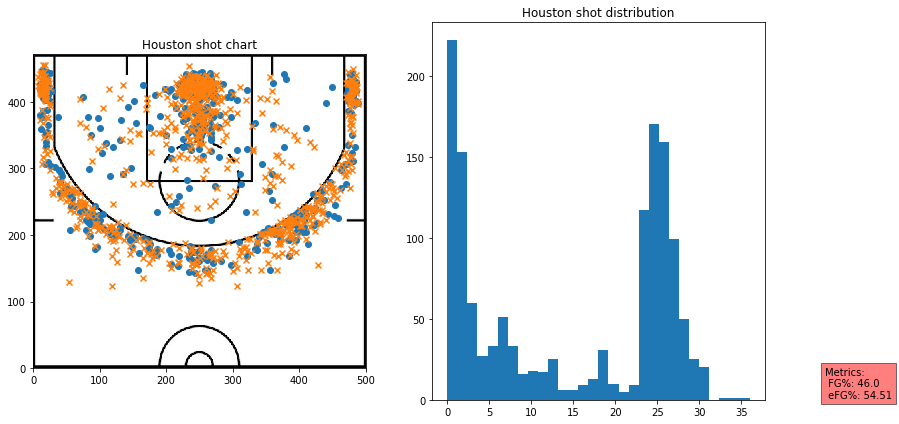

In [24]:
plot_team(shots_2019,"Houston",date_range=12)

In [25]:
print(list_teams(shots_2019))

0          LA Lakers
85       LA Clippers
166      New Orleans
268          Toronto
369        Milwaukee
451           Boston
542          Houston
645       Washington
736          Detroit
908        Minnesota
969     Philadelphia
1124            Utah
1392       Charlotte
1476      Sacramento
1572         Atlanta
1823    Golden State
1922        New York
2004         Orlando
2092          Dallas
2176          Denver
2734        Brooklyn
2835        Portland
2920        Oklahoma
3353           Miami
3877     San Antonio
4057         Chicago
4579       Cleveland
5019         Phoenix
5646         Memphis
5911         Indiana
Name: team, dtype: object


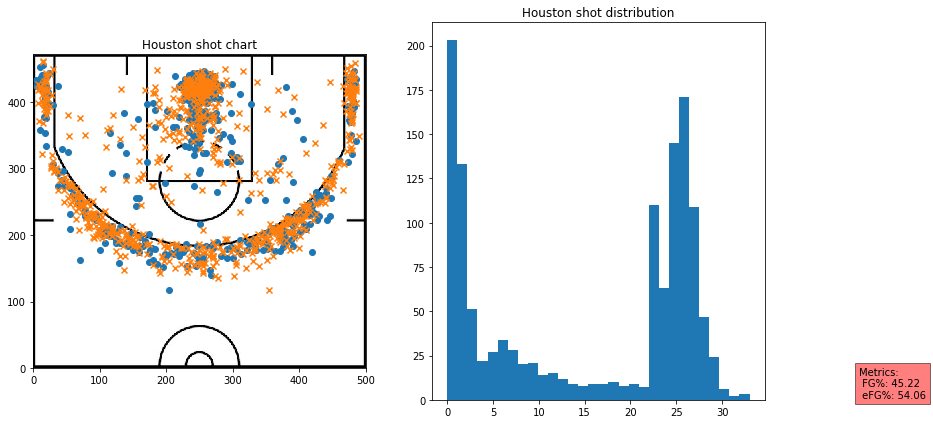

In [26]:
plot_team(shots_2019,"Houston",date_range=11)

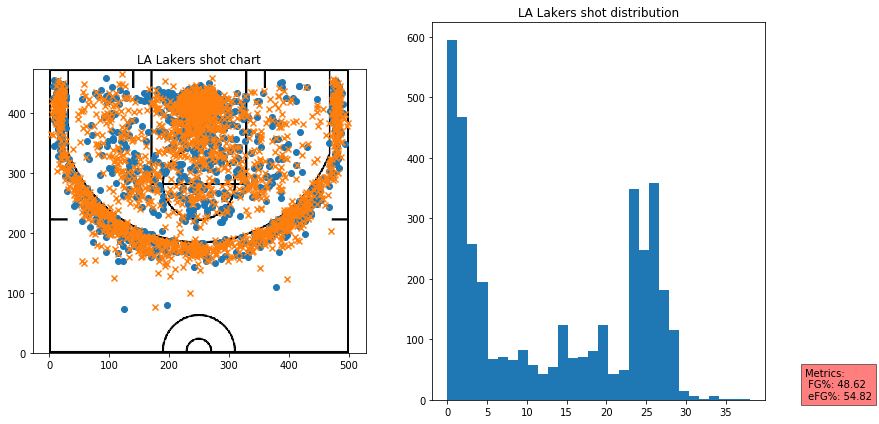

In [27]:
plot_team(shots_2019,"LA Lakers")

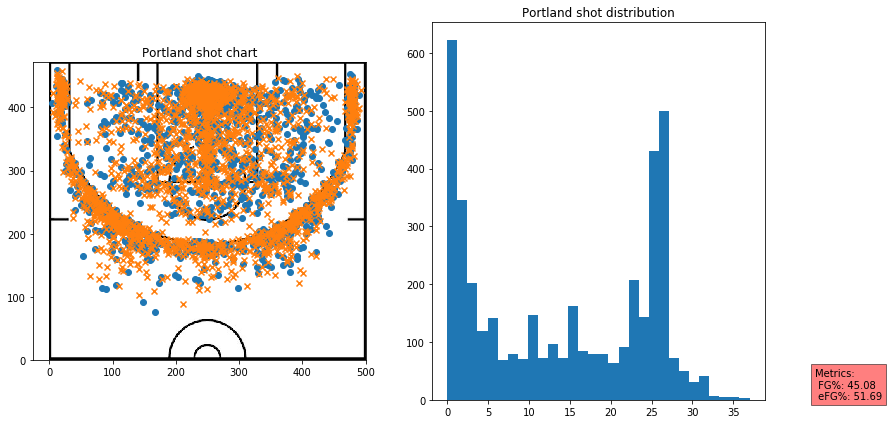

In [28]:
plot_team(shots_2019,"Portland")

## Plot winner shot chart

In [29]:
#export
def plot_winner(df:pd.DataFrame, game_id:str,made:bool=True,missed:bool=True,attempt:str="all", distance:Union[str,List[str]]="all"):
    "Plots the shot chart for the winner team of `game_id`"
    plt.figure(figsize=(2 * Config().fig_height/Config().my_dpi, Config().fig_width/Config().my_dpi), dpi=Config().my_dpi)
    #find winner first
    winner = df.loc[df["game_id"]==game_id].iloc[0]["winner"]
    plt.subplot(1, 2, 1)
    plt.title(winner+ " shot chart")
    img = plt.imread("http://d2p3bygnnzw9w3.cloudfront.net/req/1/images/bbr/nbahalfcourt.png")
    implot = plt.imshow(img, extent=[0,500,0,472])
    if attempt == "2-pointer":
        if distance == "all":
            shots_df = df.loc[(df["game_id"]==game_id) & (df["team"]==winner) & (df["attempt"]=="2-pointer")]
        else:
            shots_df = df.loc[(df["game_id"]==game_id) & (df["team"]==winner) & (df["attempt"]=="2-pointer") & (df["distance"].isin(distance))]
    elif attempt == "3-pointer":
        if distance == "all":
            shots_df = df.loc[(df["game_id"]==game_id) & (df["team"]==winner) & (df["attempt"]=="3-pointer")]
        else:
            shots_df = df.loc[(df["game_id"]==game_id) & (df["team"]==winner) & (df["attempt"]=="2-pointer") & (df["distance"].isin(distance))]
    else:
        if distance == "all":
            shots_df = df.loc[(df["game_id"]==game_id) & (df["team"]==winner)]
        else:
            shots_df = df.loc[(df["game_id"]==game_id) & (df["team"]==winner) & (df["distance"].isin(distance))]
    #misses vs made
    if made:
        mades_df = shots_df.loc[shots_df['outcome']=='made']
        ys = mades_df['x'].apply(lambda x: x.split("px")[0]).to_list()
        ys = [Y_MODIFIER - int(x) for x in ys]
        xs = mades_df['y'].apply(lambda x: int(x.split("px")[0])).to_list()
        xs = [x + X_MODIFIER for x in xs]
        plt.scatter(xs,ys)
    if missed:
        misses_df = shots_df.loc[shots_df['outcome']=='missed']
        ys = misses_df['x'].apply(lambda x: x.split("px")[0]).to_list()
        ys = [Y_MODIFIER - int(x) for x in ys]
        xs = misses_df['y'].apply(lambda x: int(x.split("px")[0])).to_list()
        xs = [x + X_MODIFIER for x in xs]
        plt.scatter(xs,ys,marker="x")
    ax = plt.subplot(1, 2, 2)
    plt.title(winner+ " shot distribution")
    distances = shots_df['distance'].apply(lambda x: int(x.split('ft')[0])).to_list()
    plt.hist(distances,bins = 30)
    fg_pct = round(_calculate_fg_pct(len(mades_df),len(shots_df)),2)
    efg_pct = round(_calculate_efg_pct(len(mades_df),len(mades_df[mades_df["attempt"]=="3-pointer"]),len(shots_df)),2)
    ax.text(42, 1, "Metrics:\n FG%: "+str(fg_pct)+"\n eFG%: "+str(efg_pct), bbox=dict(facecolor='red', alpha=0.5))
    plt.show()

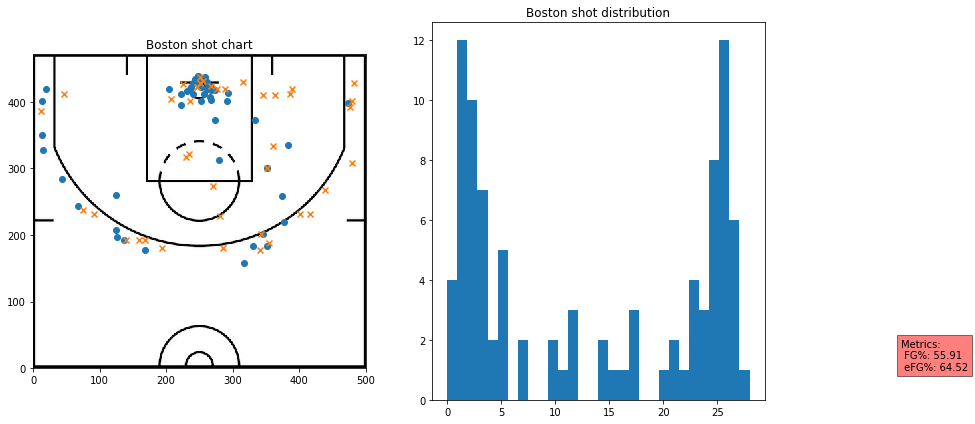

In [30]:
plot_winner(shots_2019,"202001200BOS")

In [31]:
#export
def plot_loser(df:pd.DataFrame, game_id:str,made:bool=True,missed:bool=True,attempt:str="all", distance:Union[str,List[str]]="all"):
    "Plots the shot chart for the loser team of `game_id`"
    plt.figure(figsize=(2 * Config().fig_height/Config().my_dpi,Config().fig_width/Config().my_dpi), dpi=Config().my_dpi)
    #find loser first
    loser = df.loc[df["game_id"]==game_id].iloc[0]["loser"]
    plt.subplot(1, 2, 1)
    plt.title(loser+ " shot chart")
    img = plt.imread("http://d2p3bygnnzw9w3.cloudfront.net/req/1/images/bbr/nbahalfcourt.png")
    implot = plt.imshow(img, extent=[0,500,0,472])
    if attempt == "2-pointer":
        if distance == "all":
            shots_df = df.loc[(df["game_id"]==game_id) & (df["team"]==loser) & (df["attempt"]=="2-pointer")]
        else:
            shots_df = df.loc[(df["game_id"]==game_id) & (df["team"]==loser) & (df["attempt"]=="2-pointer") & (df["distance"].isin(distance))]
    elif attempt == "3-pointer":
        if distance == "all":
            shots_df = df.loc[(df["game_id"]==game_id) & (df["team"]==loser) & (df["attempt"]=="3-pointer")]
        else:
            shots_df = df.loc[(df["game_id"]==game_id) & (df["team"]==loser) & (df["attempt"]=="2-pointer") & (df["distance"].isin(distance))]
    else:
        if distance == "all":
            shots_df = df.loc[(df["game_id"]==game_id) & (df["team"]==loser)]
        else:
            shots_df = df.loc[(df["game_id"]==game_id) & (df["team"]==loser) & (df["distance"].isin(distance))]
    #misses vs made
    if made:
        mades_df = shots_df.loc[shots_df['outcome']=='made']
        ys = mades_df['x'].apply(lambda x: x.split("px")[0]).to_list()
        ys = [Y_MODIFIER - int(x) for x in ys]
        xs = mades_df['y'].apply(lambda x: int(x.split("px")[0])).to_list()
        xs = [x + X_MODIFIER for x in xs]
        plt.scatter(xs,ys)
    if missed:
        misses_df = shots_df.loc[shots_df['outcome']=='missed']
        ys = misses_df['x'].apply(lambda x: x.split("px")[0]).to_list()
        ys = [Y_MODIFIER - int(x) for x in ys]
        xs = misses_df['y'].apply(lambda x: int(x.split("px")[0])).to_list()
        xs = [x + X_MODIFIER for x in xs]
        plt.scatter(xs,ys,marker="x")
    ax = plt.subplot(1, 2, 2)
    plt.title(loser+ " shot distribution")
    distances = shots_df['distance'].apply(lambda x: int(x.split('ft')[0])).to_list()
    plt.hist(distances,bins = 30)
    fg_pct = round(_calculate_fg_pct(len(mades_df),len(shots_df)),2)
    efg_pct = round(_calculate_efg_pct(len(mades_df),len(mades_df[mades_df["attempt"]=="3-pointer"]),len(shots_df)),2)
    ax.text(35, 1, "Metrics:\n FG%: "+str(fg_pct)+"\n eFG%: "+str(efg_pct), bbox=dict(facecolor='red', alpha=0.5))
    plt.show()

In [32]:
list_game_ids(shots_2019, 2020, 1,20)

112625    202001200ATL
112973    202001200WAS
113143    202001200UTA
113322    202001200POR
113537    202001200PHO
113704    202001200MIN
113885    202001200MIL
114055    202001200MIA
114244    202001200MEM
114435    202001200HOU
114623    202001200CLE
114802    202001200CHO
114970    202001200BRK
115145    202001200BOS
Name: game_id, dtype: object

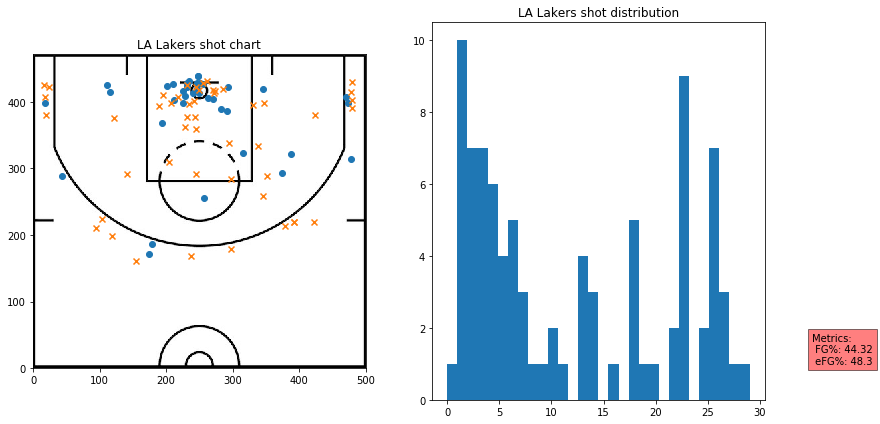

In [33]:
plot_loser(shots_2019,"202001200BOS")

## List players who took shots for a team

In [34]:
#export
def list_team_players(df, team):
    return df.loc[df['team']==team].groupby('shots_by').shots_by.count().reset_index(name='count').sort_values(['count'], ascending=False)

In [37]:
list_team_players(shots_2019,'Golden State')

,shots_by,count
0,Alec Burks,532
2,D'Angelo Russell,519
6,Glenn Robinson,440
5,Eric Paschall,433
8,Jordan Poole,328
3,Damion Lee,294
10,Ky Bowman,262
12,Omari Spellman,254
14,Willie Cauley-Stein,252
4,Draymond Green,251


## Plot shot chart - player - full season

In [95]:
#export
def plot_player(df:pd.DataFrame, player:str, date_range:Union[str,tuple,int]="all",made:bool=True,missed:bool=True,attempt:str="all",distance:Union[str,List[str]]="all"):
    "Plots shot chart of `player` for the full season"
    plt.figure(figsize=(2*Config().fig_height/Config().my_dpi, Config().fig_width/Config().my_dpi), dpi=Config().my_dpi)
    plt.subplot(1, 2, 1)
    plt.title(player+ " shot chart")
    img = plt.imread("http://d2p3bygnnzw9w3.cloudfront.net/req/1/images/bbr/nbahalfcourt.png")
    implot = plt.imshow(img, extent=[0,500,0,472])
    if date_range == "all":
        player_df = df.loc[(df["shots_by"]==player)]
    elif type(date_range) == int:
        #means month
        player_df = df.loc[(df["shots_by"]==player) & (df["month"]==date_range)]
    else:
        #custom date range in the form of ((from_y,from_m,from_d),(to_y,to_m,to_d))
        from_index = df[(df["year"]==date_range[0][0]) & (df["month"]==date_range[0][1]) & (df["day"]==date_range[0][2])].index[0]
        to_index = df[(df["year"]==date_range[1][0]) & (df["month"]==date_range[1][1]) & (df["day"]==date_range[1][2])].index[0]
        player_df = df.iloc[[from_index,to_index]]
    if attempt == "2-pointer":
        if distance == "all":
            player_df = player_df.loc[(df['shots_by']==player) & (player_df['attempt']=="2-pointer")]
        else:
            player_df = player_df.loc[(df['shots_by']==player) & (player_df['attempt']=="2-pointer") & (player_df["distance"].isin(distance))]
    elif attempt == "3-pointer":
        if distance == "all":
            player_df = player_df.loc[(player_df['shots_by']==player) & (player_df['attempt']=="3-pointer")]
        else:
            player_df = player_df.loc[(df['shots_by']==player) & (player_df['attempt']=="3-pointer") & (player_df["distance"].isin(distance))]
    else:
        if distance == "all":
            player_df = player_df.loc[(df['shots_by']==player)]
        else:    
            player_df = player_df.loc[(df['shots_by']==player) & (player_df["distance"].isin(distance))]
    if made:
        mades_df = player_df.loc[player_df['outcome']=='made']
        ys = mades_df['x'].apply(lambda x: x.split("px")[0]).to_list()
        ys = [Y_MODIFIER - int(x) for x in ys]
        xs = mades_df['y'].apply(lambda x: int(x.split("px")[0])).to_list()
        xs = [x + X_MODIFIER for x in xs]
        plt.scatter(xs,ys,color="g")
#         ax = plt.subplot(1, 2, 2)
#         plt.title(player+ " shot distribution")
#         distances = player_df['distance'].apply(lambda x: int(x.split('ft')[0])).to_list()
#         plt.hist(distances,bins = 30)
        fg_pct = round(_calculate_fg_pct(len(mades_df),len(player_df)),2)
        efg_pct = round(_calculate_efg_pct(len(mades_df),len(mades_df[mades_df["attempt"]=="3-pointer"]),len(player_df)),2)
#         ax.text(45, 1, "Metrics:\n FG%: "+str(fg_pct)+"\n eFG%: "+str(efg_pct), bbox=dict(facecolor='red', alpha=0.5))
    if missed:
        misses_df = player_df.loc[player_df['outcome']=='missed']
        ys = misses_df['x'].apply(lambda x: x.split("px")[0]).to_list()
        ys = [Y_MODIFIER - int(x) for x in ys]
        xs = misses_df['y'].apply(lambda x: int(x.split("px")[0])).to_list()
        xs = [x + X_MODIFIER for x in xs]
        plt.scatter(xs,ys,marker="x",color="r")
    if made:
        ax = plt.subplot(1, 2, 2)
        plt.title(player+ " shot distribution")
        distances = player_df['distance'].apply(lambda x: int(x.split('ft')[0])).to_list()
        if type(distance) == list:
            plt.hist(distances,bins = len(distance))
            ax.text(len(distance) + 13, 1, "Metrics:\n FG%: "+str(fg_pct)+"\n eFG%: "+str(efg_pct), bbox=dict(facecolor='red', alpha=0.5))
        else:
            plt.hist(distances,bins = 30)
            ax.text(30 + 5, 1, "Metrics:\n FG%: "+str(fg_pct)+"\n eFG%: "+str(efg_pct), bbox=dict(facecolor='red', alpha=0.5))
    plt.show()

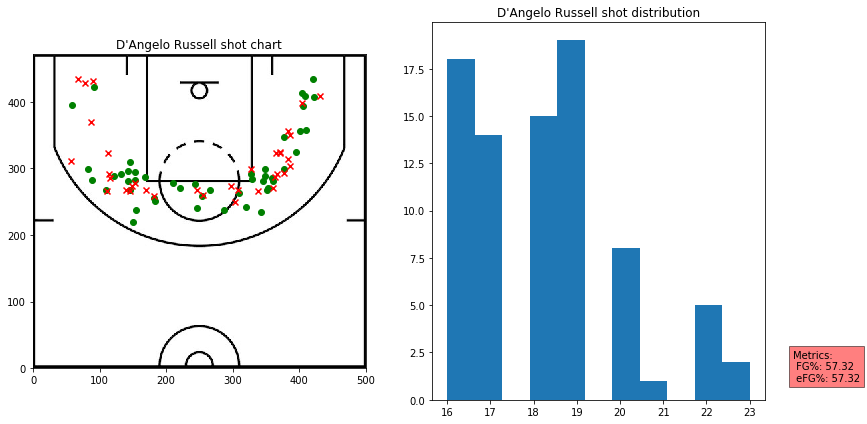

In [96]:
plot_player(shots_2019,"D'Angelo Russell",distance=["16ft","17ft","18ft","19ft","20ft","21ft","22ft","23ft","24ft","25ft","26ft"],attempt="2-pointer")

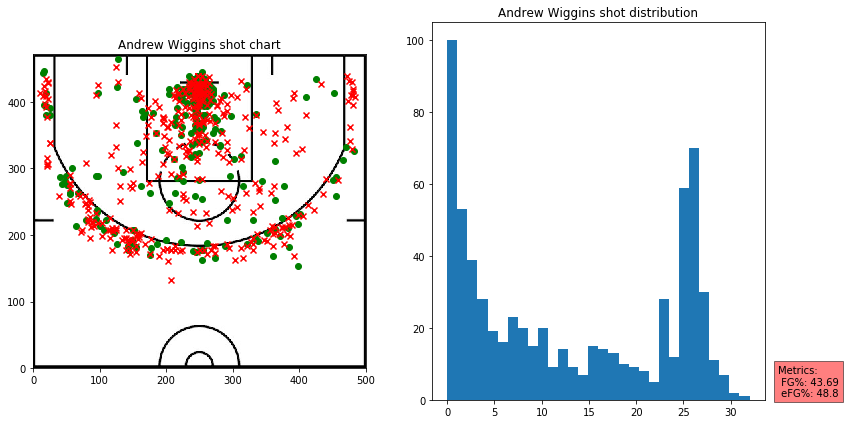

In [97]:
plot_player(shots_2019,"Andrew Wiggins")

## Finding out the least effective shot of 2019

In [98]:
shots_2019 = make_df(untar_data(URLs.SHOTS_2019))

In [99]:
#export
def least_effective_shot_team(df,team:str,metric:str="efg"):
    distances = ["0ft","1ft","2ft","3ft","4ft","5ft","6ft","7ft","8ft","9ft","10ft","11ft","12ft","13ft","14ft","15ft","16ft","17ft","18ft","19ft","20ft","21ft","22ft","23ft","24ft","25ft","26ft","27ft","28ft","29ft","30ft"]
    max_fg = 101
    max_efg = 101
    final_distance = ""
    for distance in distances:
        team_df = df.loc[(df["team"]==team) & (df["distance"]==distance)]
        fg_pct = _calculate_fg_pct(len(team_df[team_df["outcome"]=="made"]),len(team_df))
        efg_pct = _calculate_efg_pct(len(team_df[team_df["outcome"]=="made"]),len(team_df[(team_df["outcome"]=="made") & (team_df["attempt"]=="3-pointer")]),len(team_df))
        if metric == "fg":
            if fg_pct < max_fg:
                max_fg = fg_pct
                max_efg = efg_pct
                final_distance = distance
        else:
            if efg_pct < max_efg:
                max_fg = fg_pct
                max_efg = efg_pct
                final_distance = distance
    team_df = df.loc[(df["team"]==team) & (df["distance"]==final_distance)]
    img = plt.imread("http://d2p3bygnnzw9w3.cloudfront.net/req/1/images/bbr/nbahalfcourt.png")
    plt.figure(figsize=(Config().fig_height/Config().my_dpi, Config().fig_width/Config().my_dpi), dpi=Config().my_dpi)
    implot = plt.imshow(img, extent=[0,500,0,472])
    plt.text(600, 100, "Distance:\n "+ final_distance+"\n\nMetrics:\n FG%: "+str(round(max_fg,2))+"\n eFG%: "+str(round(max_efg,2)), bbox=dict(facecolor='red', alpha=0.5))
    mades_df = team_df.loc[team_df['outcome']=='made']
    ys = mades_df['x'].apply(lambda x: x.split("px")[0]).to_list()
    ys = [Y_MODIFIER - int(x) for x in ys]
    xs = mades_df['y'].apply(lambda x: int(x.split("px")[0])).to_list()
    xs = [x + X_MODIFIER for x in xs]
    plt.scatter(xs,ys)
    misses_df = team_df.loc[team_df['outcome']=='missed']
    ys = misses_df['x'].apply(lambda x: x.split("px")[0]).to_list()
    ys = [Y_MODIFIER - int(x) for x in ys]
    xs = misses_df['y'].apply(lambda x: int(x.split("px")[0])).to_list()
    xs = [x + X_MODIFIER for x in xs]
    plt.scatter(xs,ys,marker="x")
    plt.show()

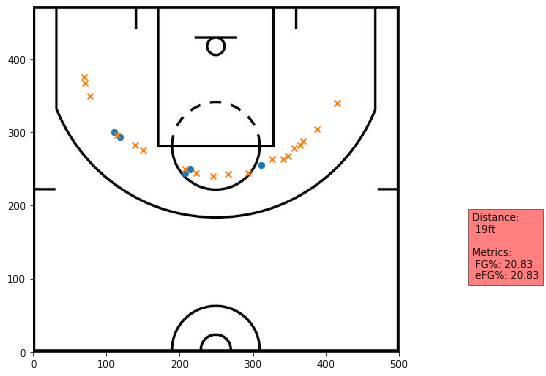

In [100]:
least_effective_shot_team(shots_2019,"Houston",metric="efg")

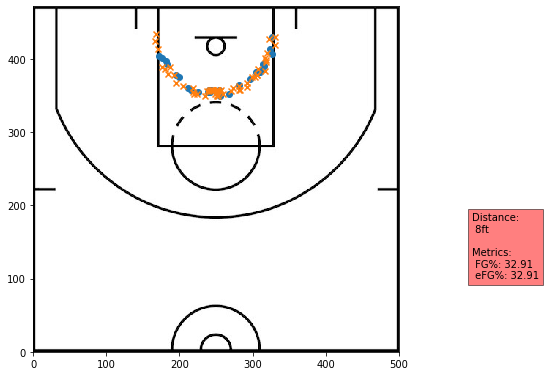

In [101]:
least_effective_shot_team(shots_2019,"Portland")

In [102]:
#export
def least_effective_shot_league(df,metric:str="efg"):
    distances = ["0ft","1ft","2ft","3ft","4ft","5ft","6ft","7ft","8ft","9ft","10ft","11ft","12ft","13ft","14ft","15ft","16ft","17ft","18ft","19ft","20ft","21ft","22ft","23ft","24ft","25ft","26ft","27ft","28ft","29ft","30ft"]
    max_fg = 101
    max_efg = 101
    final_distance = ""
    for distance in distances:
        team_df = df.loc[(df["distance"]==distance)]
        fg_pct = _calculate_fg_pct(len(team_df[team_df["outcome"]=="made"]),len(team_df))
        efg_pct = _calculate_efg_pct(len(team_df[team_df["outcome"]=="made"]),len(team_df[(team_df["outcome"]=="made") & (team_df["attempt"]=="3-pointer")]),len(team_df))
        if metric == "fg":
            if fg_pct < max_fg:
                max_fg = fg_pct
                max_efg = efg_pct
                final_distance = distance
        else:
            if efg_pct < max_efg:
                max_fg = fg_pct
                max_efg = efg_pct
                final_distance = distance
    team_df = df.loc[(df["distance"]==final_distance)]
    plt.figure(figsize=(Config().fig_height/Config().my_dpi, Config().fig_width/Config().my_dpi), dpi=Config().my_dpi)
    img = plt.imread("http://d2p3bygnnzw9w3.cloudfront.net/req/1/images/bbr/nbahalfcourt.png")
    implot = plt.imshow(img, extent=[0,500,0,472])
    plt.text(600, 100, "Distance:\n "+ final_distance+"\n\nMetrics:\n FG%: "+str(round(max_fg,2))+"\n eFG%: "+str(round(max_efg,2)), bbox=dict(facecolor='red', alpha=0.5))
    mades_df = team_df.loc[team_df['outcome']=='made']
    ys = mades_df['x'].apply(lambda x: x.split("px")[0]).to_list()
    ys = [Y_MODIFIER - int(x) for x in ys]
    xs = mades_df['y'].apply(lambda x: int(x.split("px")[0])).to_list()
    xs = [x + X_MODIFIER for x in xs]
    plt.scatter(xs,ys)
    misses_df = team_df.loc[team_df['outcome']=='missed']
    ys = misses_df['x'].apply(lambda x: x.split("px")[0]).to_list()
    ys = [Y_MODIFIER - int(x) for x in ys]
    xs = misses_df['y'].apply(lambda x: int(x.split("px")[0])).to_list()
    xs = [x + X_MODIFIER for x in xs]
    plt.scatter(xs,ys,marker="x")
    plt.show()

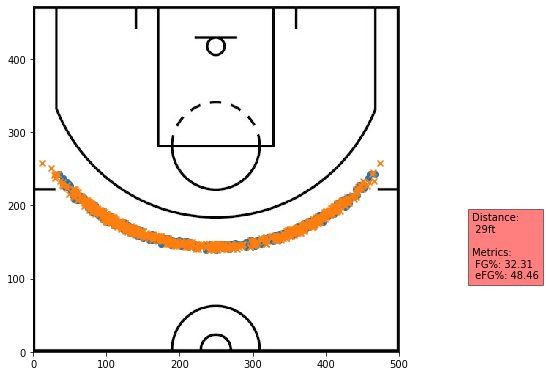

In [103]:
least_effective_shot_league(shots_2019,metric="fg")

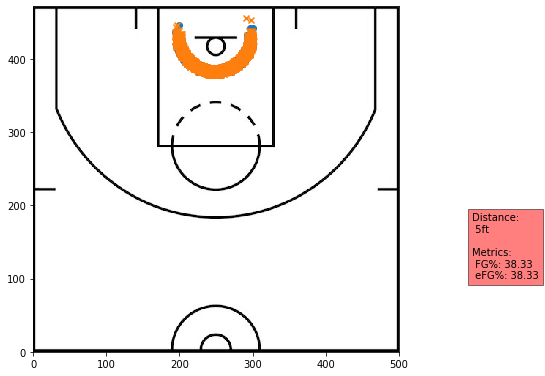

In [104]:
least_effective_shot_league(shots_2019,metric="efg")

In [105]:
#export
def most_effective_shot_league(df,metric:str="efg"):
    distances = ["3ft","4ft","5ft","6ft","7ft","8ft","9ft","10ft","11ft","12ft","13ft","14ft","15ft","16ft","17ft","18ft","19ft","20ft","21ft","22ft","23ft","24ft","25ft","26ft","27ft","28ft","29ft","30ft"]
    max_fg = -1
    max_efg = -1
    final_distance = ""
    for distance in distances:
        team_df = df.loc[(df["distance"]==distance)]
        fg_pct = _calculate_fg_pct(len(team_df[team_df["outcome"]=="made"]),len(team_df))
        efg_pct = _calculate_efg_pct(len(team_df[team_df["outcome"]=="made"]),len(team_df[(team_df["outcome"]=="made") & (team_df["attempt"]=="3-pointer")]),len(team_df))
        if metric == "fg":
            if fg_pct > max_fg:
                max_fg = fg_pct
                max_efg = efg_pct
                final_distance = distance
        else:
            if efg_pct > max_efg:
                max_fg = fg_pct
                max_efg = efg_pct
                final_distance = distance
    team_df = df.loc[(df["distance"]==final_distance)]
    img = plt.imread("http://d2p3bygnnzw9w3.cloudfront.net/req/1/images/bbr/nbahalfcourt.png")
    plt.figure(figsize=(Config().fig_height/Config().my_dpi, Config().fig_width/Config().my_dpi), dpi=Config().my_dpi)
    implot = plt.imshow(img, extent=[0,500,0,472])
    plt.text(600, 100, "Distance:\n "+ final_distance+"\n\nMetrics:\n FG%: "+str(round(max_fg,2))+"\n eFG%: "+str(round(max_efg,2)), bbox=dict(facecolor='red', alpha=0.5))
    mades_df = team_df.loc[team_df['outcome']=='made']
    ys = mades_df['x'].apply(lambda x: x.split("px")[0]).to_list()
    ys = [Y_MODIFIER - int(x) for x in ys]
    xs = mades_df['y'].apply(lambda x: int(x.split("px")[0])).to_list()
    xs = [x + X_MODIFIER for x in xs]
    plt.scatter(xs,ys)
    misses_df = team_df.loc[team_df['outcome']=='missed']
    ys = misses_df['x'].apply(lambda x: x.split("px")[0]).to_list()
    ys = [Y_MODIFIER- int(x) for x in ys]
    xs = misses_df['y'].apply(lambda x: int(x.split("px")[0])).to_list()
    xs = [x + X_MODIFIER for x in xs]
    plt.scatter(xs,ys,marker="x")
    plt.show()

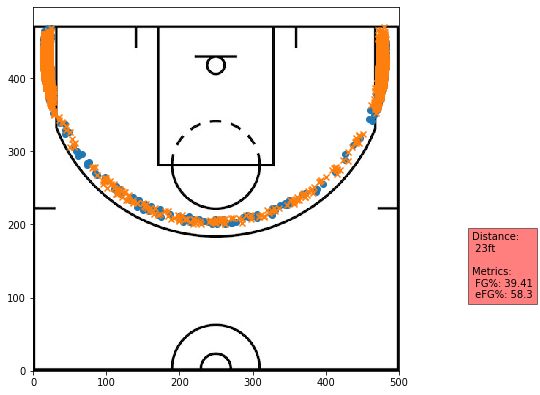

In [106]:
most_effective_shot_league(shots_2019,metric="efg")

## Least effective field goal - player

In [146]:
#export
def least_effective_shot_player(df,player:str,metric:str="efg", exclude:Union[str,List["str"]]="none"):
    distances = ["0ft","1ft","2ft","3ft","4ft","5ft","6ft","7ft","8ft","9ft","10ft","11ft","12ft","13ft","14ft","15ft","16ft","17ft","18ft","19ft","20ft","21ft","22ft","23ft","24ft","25ft","26ft","27ft","28ft","29ft","30ft"]
    if type(exclude) == list:
        distances = list(set(distances) - set(exclude))
    max_fg = 101
    max_efg = 101
    final_distance = ""
    for distance in distances:
        player_df = df.loc[(df["shots_by"]==player) & (df["distance"]==distance)]
        fg_pct = _calculate_fg_pct(len(player_df[player_df["outcome"]=="made"]),len(player_df))
        efg_pct = _calculate_efg_pct(len(player_df[player_df["outcome"]=="made"]),len(player_df[(player_df["outcome"]=="made") & (player_df["attempt"]=="3-pointer")]),len(player_df))
        if metric == "fg":
            if fg_pct < max_fg:
                max_fg = fg_pct
                max_efg = efg_pct
                final_distance = distance
        else:
            if efg_pct < max_efg:
                max_fg = fg_pct
                max_efg = efg_pct
                final_distance = distance
    player_df = df.loc[(df["shots_by"]==player) & (df["distance"]==final_distance)]
    plt.figure(figsize=(2*Config().fig_height/Config().my_dpi, Config().fig_width/Config().my_dpi), dpi=Config().my_dpi)
    plt.subplot(1, 2, 1)
    plt.title(player+ " shot chart")
    img = plt.imread("http://d2p3bygnnzw9w3.cloudfront.net/req/1/images/bbr/nbahalfcourt.png")
    implot = plt.imshow(img, extent=[0,500,0,472])
    plt.text(600, 100, "Distance:\n "+ final_distance+"\n\nMetrics:\n FG%: "+str(round(max_fg,2))+"\n eFG%: "+str(round(max_efg,2)), bbox=dict(facecolor='red', alpha=0.5))
    mades_df = player_df.loc[player_df['outcome']=='made']
    ys = mades_df['x'].apply(lambda x: x.split("px")[0]).to_list()
    ys = [Y_MODIFIER - int(x) for x in ys]
    xs = mades_df['y'].apply(lambda x: int(x.split("px")[0])).to_list()
    xs = [x + X_MODIFIER for x in xs]
    plt.scatter(xs,ys)
    misses_df = player_df.loc[player_df['outcome']=='missed']
    ys = misses_df['x'].apply(lambda x: x.split("px")[0]).to_list()
    ys = [Y_MODIFIER - int(x) for x in ys]
    xs = misses_df['y'].apply(lambda x: int(x.split("px")[0])).to_list()
    xs = [x + X_MODIFIER for x in xs]
    plt.scatter(xs,ys,marker="x")
    ax = plt.subplot(1, 2, 2)
    plt.title(player+ " shot distribution")
    #I would still like to see the whole overall volume
    all_shots = df.loc[(df["shots_by"]==player)]
    distances = all_shots['distance'].apply(lambda x: int(x.split('ft')[0])).to_list()
    plt.hist(distances,bins = 30)
    ax.text(35 + 5, 1, "Metrics:\n FG%: "+str(fg_pct)+"\n eFG%: "+str(efg_pct), bbox=dict(facecolor='red', alpha=0.5)) 
    plt.show()

In [147]:
list_team_players(shots_2019,"Portland")

,shots_by,count
4,Damian Lillard,836
2,CJ McCollum,793
6,Hassan Whiteside,444
3,Carmelo Anthony,421
0,Anfernee Simons,392
8,Kent Bazemore,322
12,Rodney Hood,172
5,Gary Trent,154
13,Skal Labissière,147
9,Mario Hezonja,130


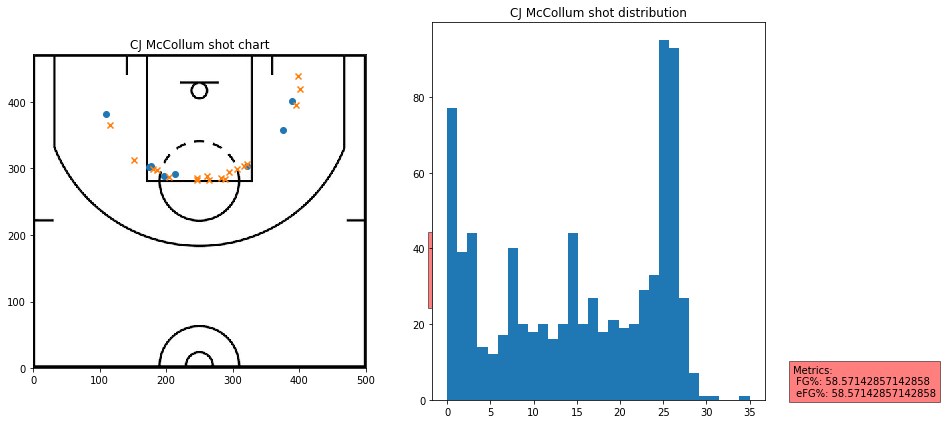

In [148]:
least_effective_shot_player(shots_2019,"CJ McCollum",exclude=["30ft","8ft"])

## Most effective field goal - player

In [140]:
#export
def most_effective_shot_player(df,player:str,metric:str="efg", exclude:Union[str,List["str"]]="none"):
    distances = ["0ft","1ft","2ft","3ft","4ft","5ft","6ft","7ft","8ft","9ft","10ft","11ft","12ft","13ft","14ft","15ft","16ft","17ft","18ft","19ft","20ft","21ft","22ft","23ft","24ft","25ft","26ft","27ft","28ft","29ft","30ft"]
    if type(exclude) == list:
        distances = list(set(distances) - set(exclude))
    max_fg = -1
    max_efg = -1
    final_distance = ""
    for distance in distances:
        player_df = df.loc[(df["shots_by"]==player) & (df["distance"]==distance)]
        fg_pct = _calculate_fg_pct(len(player_df[player_df["outcome"]=="made"]),len(player_df))
        efg_pct = _calculate_efg_pct(len(player_df[player_df["outcome"]=="made"]),len(player_df[(player_df["outcome"]=="made") & (player_df["attempt"]=="3-pointer")]),len(player_df))
        if metric == "fg":
            if fg_pct > max_fg:
                max_fg = fg_pct
                max_efg = efg_pct
                final_distance = distance
        else:
            if efg_pct > max_efg:
                max_fg = fg_pct
                max_efg = efg_pct
                final_distance = distance
    player_df = df.loc[(df["shots_by"]==player) & (df["distance"]==final_distance)]
    plt.figure(figsize=(2*Config().fig_height/Config().my_dpi, Config().fig_width/Config().my_dpi), dpi=Config().my_dpi)
    plt.subplot(1, 2, 1)
    plt.title(player+ " shot chart")
    img = plt.imread("http://d2p3bygnnzw9w3.cloudfront.net/req/1/images/bbr/nbahalfcourt.png")
    implot = plt.imshow(img, extent=[0,500,0,472])
    plt.text(600, 100, "Distance:\n "+ final_distance+"\n\nMetrics:\n FG%: "+str(round(max_fg,2))+"\n eFG%: "+str(round(max_efg,2)), bbox=dict(facecolor='red', alpha=0.5))
    mades_df = player_df.loc[player_df['outcome']=='made']
    ys = mades_df['x'].apply(lambda x: x.split("px")[0]).to_list()
    ys = [Y_MODIFIER - int(x) for x in ys]
    xs = mades_df['y'].apply(lambda x: int(x.split("px")[0])).to_list()
    xs = [x + X_MODIFIER for x in xs]
    plt.scatter(xs,ys)
    misses_df = player_df.loc[player_df['outcome']=='missed']
    ys = misses_df['x'].apply(lambda x: x.split("px")[0]).to_list()
    ys = [Y_MODIFIER - int(x) for x in ys]
    xs = misses_df['y'].apply(lambda x: int(x.split("px")[0])).to_list()
    xs = [x + X_MODIFIER for x in xs]
    plt.scatter(xs,ys,marker="x")
    ax = plt.subplot(1, 2, 2)
    plt.title(player+ " shot distribution")
    #I would still like to see the whole overall volume
    all_shots = df.loc[(df["shots_by"]==player)]
    distances = all_shots['distance'].apply(lambda x: int(x.split('ft')[0])).to_list()
    plt.hist(distances,bins = 30)
    ax.text(35 + 5, 1, "Metrics:\n FG%: "+str(fg_pct)+"\n eFG%: "+str(efg_pct), bbox=dict(facecolor='red', alpha=0.5))
    plt.show()

In [141]:
list_team_players(shots_2019,"Portland")

,shots_by,count
4,Damian Lillard,836
2,CJ McCollum,793
6,Hassan Whiteside,444
3,Carmelo Anthony,421
0,Anfernee Simons,392
8,Kent Bazemore,322
12,Rodney Hood,172
5,Gary Trent,154
13,Skal Labissière,147
9,Mario Hezonja,130


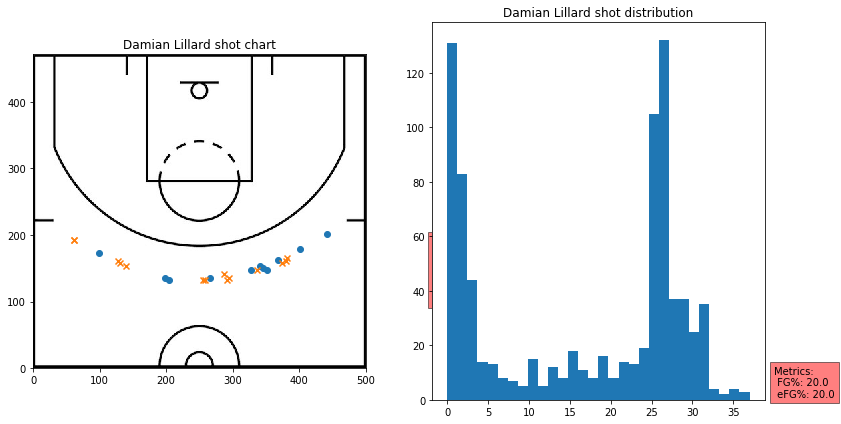

In [142]:
most_effective_shot_player(shots_2019,"Damian Lillard", exclude=["0ft","21ft","1ft"])

## Export -

In [149]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_core.ipynb.
Converted index.ipynb.


In [319]:
F = plt.gcf()

# Now check everything with the defaults:
DPI = F.get_dpi()
print("DPI:", DPI)

DPI: 72.0


<Figure size 432x288 with 0 Axes>